![](unimed.png)

---
## Feature Selection

Neste hands-on, queremos revisitar as técnicas de pré-processamento, como normalizações **(Max-Min, Z-score)** e discretização de dados. Além disso, aprederemos métodos para seleção de features, como **PCA** e **Information Gain**. Além disso, vamos trabalhar com a base do Titanic que usamos nas atividades anteriores, que estão disponíveis no arquivo **titanic_data.csv**.

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

## Parte 1 - Pré-processamento

Primeiro, vamos refazer o pré-processamento de dados que haviamos feito anteriormente.

In [3]:
"""Faça a leitura do arquivo salvando seu conteúdo na variável titanic e depois visualize suas 5 primeiras linhas"""
titanic = pd.read_csv('titanic_data.csv')

"""Renomeie as colunas do DataFrame para facilitar o entendimento"""
titanic.columns = ['IdPassageiro','Sobreviveu?','Classe','Nome','Sexo','Idade','Irmãos/Cônjuge','Pais/Crianças','Bilhete','Tarifa','Cabine','Embarque']

""" Tornar a coluna IdPassageiro índice do DataFrame"""
titanic = titanic.set_index('IdPassageiro')

"""Remova as colunas Nome, Bilhete e Cabine do DataFrame"""
titanic.drop(['Nome','Bilhete','Cabine'], axis=1, inplace = True)

titanic.head(5)

,Sobreviveu?,Classe,Sexo,Idade,Irmãos/Cônjuge,Pais/Crianças,Tarifa,Embarque
IdPassageiro,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


### Missing Values

In [4]:
""" Verificar se existem valores nulos."""

titanic.isna().sum()

Sobreviveu?         0
Classe              0
Sexo                0
Idade             177
Irmãos/Cônjuge      0
Pais/Crianças       0
Tarifa              0
Embarque            2
dtype: int64

Observe que, dentre os 891 registros do DataFrame, a coluna *Idade* tem 177 valores nulos e a coluna *Embarque* possui 2 valores nulos. No caso do Titanic, pode ser que a idade de certos passageiros fosse desconhecida ou não tenha sido recuperada.

Dados faltantes ou incorretos acontecem com bastante frequência, e é nossa tarefa tratá-los da forma correta. 
Para preencher valores faltantes podemos utilizar diversos métodos, como:
<ul>
    <li> Remoção das linhas que possuem algum valor faltante</li> 
    <li> Subistituição do atributo faltante pela média/mediana/moda dos atributos </li>
</ul>

Neste caso substituíremos os valores faltantes da coluna **Idade** pela **média** das idades dos passageiros. Na coluna **Embarque**, por sua vez, não faz sentido calcular a média/mediana de dados categóricos. Por isso, iremos substituir os valores pela **moda** (valor mais frequente).

In [5]:
"""Verificar as estatísticas do DataFrame."""

titanic.describe()

,Sobreviveu?,Classe,Idade,Irmãos/Cônjuge,Pais/Crianças,Tarifa
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
"""Substituir os valores nulos de Idade pela média da coluna."""

titanic['Idade'].fillna(titanic['Idade'].mean(), inplace = True)
titanic.isna().sum()

Sobreviveu?       0
Classe            0
Sexo              0
Idade             0
Irmãos/Cônjuge    0
Pais/Crianças     0
Tarifa            0
Embarque          2
dtype: int64

In [7]:
"""Substituir os valores nulos de Embarque pela moda da coluna."""
print('Moda: ', titanic['Embarque'].dropna().mode()[0])
titanic['Embarque'].fillna(titanic['Embarque'].mode()[0], inplace = True)
titanic.isna().sum()

Moda:  S


Sobreviveu?       0
Classe            0
Sexo              0
Idade             0
Irmãos/Cônjuge    0
Pais/Crianças     0
Tarifa            0
Embarque          0
dtype: int64

### Discretização de Dados Numéricos

A discretização de dados pode ajudar bastante quando temos dados numéricos e queremos quebrar os valores em intervalos que representam diferentes categorias. Esse processo pode ser útil em situações onde os dados da coluna não tem correlação com a coluna target. Dessa forma, discretizar os dados pode trazer evidências que não eram tão claras anteriormente.

Se verificarmos a correlação da coluna **Idade** com a coluna **Sobreviveu?**, por exemplo, vemos que praticamente não há correlação. 

In [8]:
"""Correlação entre Idade e Sobrevivência."""

titanic['Idade'].corr(titanic['Sobreviveu?'])

-0.06980851528714314

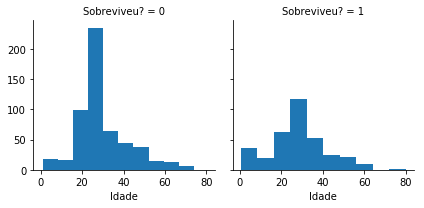

In [9]:
"""Relação entre Idade e Sobrevivência."""

import seaborn as sns
g = sns.FacetGrid(titanic, col='Sobreviveu?')
g.map(plt.hist, 'Idade', bins=10)

Agora, vamos discretizar a coluna **Idade** em 4 categorias: Criança, Jovem, Adulto, Idoso. Depois, vamos analisar a distribuição de sobreviventes em cada categoria.

In [11]:
""" Criar uma nova coluna 'IdadeDisc' no DataFrame com os valores normalizados da coluna Idade. Regras:
    - Para pessoas entre 0 e 15 anos, atribuir o valor 'Criança'.
    - Para pessoas entre 15 e 25 anos, atribuir o valor 'Jovem'.
    - Para pessoas entre 25 e 60 anos, atribuir o valor 'Jovem'.
    - Para pessoas com mais de 60 anos, atribuir o valor 'Idoso'. """

titanic['IdadeDisc'] = pd.cut(titanic['Idade'], bins = [0,15, 25, 60, 80], 
                              labels=['Criança', 'Jovem', 'Adulto', 'Idoso'])
titanic.head()

,Sobreviveu?,Classe,Sexo,Idade,Irmãos/Cônjuge,Pais/Crianças,Tarifa,Embarque,IdadeDisc
IdPassageiro,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,Jovem
2,1,1,female,38.0,1,0,71.2833,C,Adulto
3,1,3,female,26.0,0,0,7.9250,S,Adulto
4,1,1,female,35.0,1,0,53.1000,S,Adulto
5,0,3,male,35.0,0,0,8.0500,S,Adulto


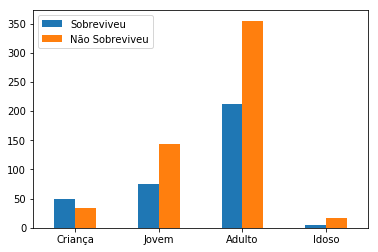

In [12]:
"""Relação entre IdadeDisc e Sobrevivência."""

survived = titanic[titanic['Sobreviveu?'] == 1].groupby('IdadeDisc')['Sobreviveu?'].count().values
not_survived = titanic[titanic['Sobreviveu?'] == 0].groupby('IdadeDisc')['Sobreviveu?'].count().values
index = titanic[titanic['Sobreviveu?'] == 1].groupby('IdadeDisc')['Sobreviveu?'].count().index.values

df = pd.DataFrame({'Sobreviveu': survived,
                   'Não Sobreviveu': not_survived}, index=index)
ax = df.plot.bar(rot=0)

Outra coluna que pode ser discretizada é a **Tarifa**. Essa coluna poderia ser categorizada em três grupos de acordo com a faixa de preço: *Barato*, *Médio* e *Caro*. Neste caso, podemos simplesmente distribuir os preços de acordo com o quantil, de forma que cada grupo contenha aproximadamente a mesma quantidade de registros ao final. 

Para isso, podemos utilizar a função **qcut()** do Pandas.

In [13]:
"""Correlação entre Tarifa e Sobrevivência."""
titanic['Tarifa'].corr(titanic['Sobreviveu?'])

0.2573065223849625

In [14]:
"""Gerar intervalos que deixam a distribuição mais equilibrada."""

intervals = pd.qcut(titanic['Tarifa'], 3).astype(str).unique()
intervals

array(['(-0.001, 8.662]', '(26.0, 512.329]', '(8.662, 26.0]'],
      dtype=object)

In [15]:
titanic['Tipo_Tarifa'] = pd.qcut(titanic['Tarifa'], 3).astype(str).map( {intervals[0]: 'Barato', 
                                                                         intervals[1]: 'Medio', 
                                                                         intervals[2]: 'Caro'} ).astype(str)
titanic.head()

,Sobreviveu?,Classe,Sexo,Idade,Irmãos/Cônjuge,Pais/Crianças,Tarifa,Embarque,IdadeDisc,Tipo_Tarifa
IdPassageiro,,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,Jovem,Barato
2,1,1,female,38.0,1,0,71.2833,C,Adulto,Medio
3,1,3,female,26.0,0,0,7.9250,S,Adulto,Barato
4,1,1,female,35.0,1,0,53.1000,S,Adulto,Medio
5,0,3,male,35.0,0,0,8.0500,S,Adulto,Barato


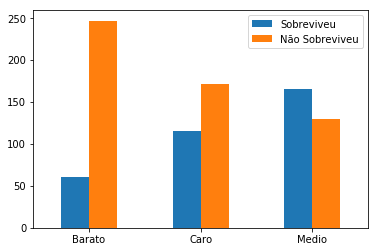

In [16]:
"""Relação entre Tipo da Tarifa e Sobrevivência."""

survived = titanic[titanic['Sobreviveu?'] == 1].groupby('Tipo_Tarifa')['Sobreviveu?'].count().values
not_survived = titanic[titanic['Sobreviveu?'] == 0].groupby('Tipo_Tarifa')['Sobreviveu?'].count().values
index = titanic[titanic['Sobreviveu?'] == 1].groupby('Tipo_Tarifa')['Sobreviveu?'].count().index.values

df = pd.DataFrame({'Sobreviveu': survived,
                   'Não Sobreviveu': not_survived}, index=index)
ax = df.plot.bar(rot=0)

### Transformação de Dados Categóricos para Numéricos

Em muitos casos, o modelo de Machine Learning que usamos para nossa tarefa não aceita dados que não sejam numéricos. Por isso, em vez de ignorar nossos dados categóricos, podemos transformar os dados categóricos em numéricos. Alguns métodos utilizados são:
* **One-hot Encoding** - Transformar cada categoria em uma coluna (*dummy variables*) que contém 1 ou 0, indicando se o registro pertence ou não àquela categoria.
* **Mapeamento** - Mapear cada categoria para um valor inteiro (0,1,2,3...). Quando o número de categorias é 2 apenas, o método geralmente é chamado de **Binarização**.

Cada um dos métodos tem suas peculiaridades. O **One-hot Encoding** aumenta o número de dimensões no espaço de features, o que pode ser muito ruim para casos onde o número de categorias é grande. Por outro lado, o **Mapeamento** pode trazer ruído para o modelo, já que os números não representam números de verdade (Operações como média não fazem sentido, por exemplo).

No caso do Titanic, vamos transformar as colunas categóricas ('Sexo', 'Embarque', 'IdadeDisc' e 'Tipo_Tarifa') em dados numéricos utilizando **Mapeamento** para 'Sexo' e 'Embarque' e **One-hot Encoding** para 'IdadeDisc' e 'Tipo_Tarifa'. 

In [17]:
"""Mapeamento para valores numéricos nas colunas 'Sexo' e 'Embarque'."""
titanic['Sexo'] = titanic['Sexo'].map( {'female': 0, 'male': 1} ).astype(int)
titanic['Embarque'] = titanic['Embarque'].map( {'S': 0, 'C': 1, 'Q':2} ).astype(int)
titanic.head()

,Sobreviveu?,Classe,Sexo,Idade,Irmãos/Cônjuge,Pais/Crianças,Tarifa,Embarque,IdadeDisc,Tipo_Tarifa
IdPassageiro,,,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,0,Jovem,Barato
2,1,1,0,38.0,1,0,71.2833,1,Adulto,Medio
3,1,3,0,26.0,0,0,7.9250,0,Adulto,Barato
4,1,1,0,35.0,1,0,53.1000,0,Adulto,Medio
5,0,3,1,35.0,0,0,8.0500,0,Adulto,Barato


In [18]:
"""One-hot Encoding para valores numéricos nas colunas 'IdadeDisc' e 'Tipo_Tarifa'."""
dummy = pd.get_dummies(titanic['IdadeDisc'])
titanic = pd.concat([titanic, dummy], axis=1)

dummy = pd.get_dummies(titanic['Tipo_Tarifa'])
titanic = pd.concat([titanic, dummy], axis=1)

titanic.drop(['IdadeDisc', 'Tipo_Tarifa'], axis=1, inplace=True)
titanic.head()

,Sobreviveu?,Classe,Sexo,Idade,Irmãos/Cônjuge,Pais/Crianças,Tarifa,Embarque,Criança,Jovem,Adulto,Idoso,Barato,Caro,Medio
IdPassageiro,,,,,,,,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,0,0,1,0,0,1,0,0
2,1,1,0,38.0,1,0,71.2833,1,0,0,1,0,0,0,1
3,1,3,0,26.0,0,0,7.9250,0,0,0,1,0,1,0,0
4,1,1,0,35.0,1,0,53.1000,0,0,0,1,0,0,0,1
5,0,3,1,35.0,0,0,8.0500,0,0,0,1,0,1,0,0


### Normalização Min-Max $[0,1]$ 

Antes de realizar as normalizações, vamos remover a coluna 'Sobreviveu?' do nosso DataFrame e salvá-la em uma variável.

In [19]:
target = titanic['Sobreviveu?']
target.head()

IdPassageiro
1    0
2    1
3    1
4    1
5    0
Name: Sobreviveu?, dtype: int64

In [20]:
titanic.drop(['Sobreviveu?'], axis=1, inplace=True)

Podemos querer normalizar atributos para oberservá-los em um intervalo de valores mais bem controlado. Vamos então normalizar nosso DataSet no intervalo $[0,1]$ utilizando a função **MinMaxScaler()** da biblioteca sklearn, que aplicará a função **min-max**, que é dada pela **fórmula**:

$$v' = \frac{v-min_A}{max_A - min_A}(nmax_A - nmin_A) + nmin_A$$

onde:
* $[nmin_A, nmax_A]$ é o intervalo no qual você deseja normalizar seus dados (no nosso caso, $[0,1]$)
* $min_A$ e $max_A$ são os atuais valores mínimo e máximo da coluna, respectivamente.

Deve-se ressaltar que a função não é aplicada em dados categóricos, logo devemos "cortar" algumas colunas do DataSet para aplicarmos a função.

In [21]:
from sklearn import preprocessing
X = titanic.values
min_max_scaler = preprocessing.MinMaxScaler()
df_minmax = min_max_scaler.fit_transform(X)
df_minmax = pd.DataFrame(df_minmax,columns=titanic.columns)
df_minmax.head()

,Classe,Sexo,Idade,Irmãos/Cônjuge,Pais/Crianças,Tarifa,Embarque,Criança,Jovem,Adulto,Idoso,Barato,Caro,Medio
0,1.0,1.0,0.271174,0.125,0.0,0.014151,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.472229,0.125,0.0,0.139136,0.5,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.321438,0.000,0.0,0.015469,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.434531,0.125,0.0,0.103644,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1.0,1.0,0.434531,0.000,0.0,0.015713,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [22]:
"""Mais uma vez vamos ver como ficam a distribuição de dados do novo DataFrame"""

df_minmax.describe().round(2)

,Classe,Sexo,Idade,Irmãos/Cônjuge,Pais/Crianças,Tarifa,Embarque,Criança,Jovem,Adulto,Idoso,Barato,Caro,Medio
count,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00
mean,0.65,0.65,0.37,0.07,0.06,0.06,0.18,0.09,0.24,0.64,0.02,0.35,0.32,0.33
std,0.42,0.48,0.16,0.14,0.13,0.10,0.32,0.29,0.43,0.48,0.16,0.48,0.47,0.47
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.50,0.00,0.27,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,1.00,1.00,0.37,0.00,0.00,0.03,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
75%,1.00,1.00,0.43,0.12,0.00,0.06,0.50,0.00,0.00,1.00,0.00,1.00,1.00,1.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


### Normalização Gaussiana (Z-Score)

In [23]:
from sklearn import preprocessing
X = titanic.values
standard_scaler = preprocessing.StandardScaler()
df_standard = standard_scaler.fit_transform(X)
df_standard = pd.DataFrame(df_standard,columns=titanic.columns)
df_standard.head()

,Classe,Sexo,Idade,Irmãos/Cônjuge,Pais/Crianças,Tarifa,Embarque,Criança,Jovem,Adulto,Idoso,Barato,Caro,Medio
0,0.827377,0.737695,-0.592481,0.432793,-0.473674,-0.502445,-0.568837,-0.320504,1.757030,-1.326090,-0.159111,1.375811,-0.691095,-0.703539
1,-1.566107,-1.355574,0.638789,0.432793,-0.473674,0.786845,1.005181,-0.320504,-0.569142,0.754097,-0.159111,-0.726844,-0.691095,1.421386
2,0.827377,-1.355574,-0.284663,-0.474545,-0.473674,-0.488854,-0.568837,-0.320504,-0.569142,0.754097,-0.159111,1.375811,-0.691095,-0.703539
3,-1.566107,-1.355574,0.407926,0.432793,-0.473674,0.420730,-0.568837,-0.320504,-0.569142,0.754097,-0.159111,-0.726844,-0.691095,1.421386
4,0.827377,0.737695,0.407926,-0.474545,-0.473674,-0.486337,-0.568837,-0.320504,-0.569142,0.754097,-0.159111,1.375811,-0.691095,-0.703539


In [24]:
"""Mais uma vez vamos ver como ficam a distribuição de dados do novo DataFrame"""

df_standard.describe().round(2)

,Classe,Sexo,Idade,Irmãos/Cônjuge,Pais/Crianças,Tarifa,Embarque,Criança,Jovem,Adulto,Idoso,Barato,Caro,Medio
count,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00
mean,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.57,-1.36,-2.25,-0.47,-0.47,-0.65,-0.57,-0.32,-0.57,-1.33,-0.16,-0.73,-0.69,-0.70
25%,-0.37,-1.36,-0.59,-0.47,-0.47,-0.49,-0.57,-0.32,-0.57,-1.33,-0.16,-0.73,-0.69,-0.70
50%,0.83,0.74,0.00,-0.47,-0.47,-0.36,-0.57,-0.32,-0.57,0.75,-0.16,-0.73,-0.69,-0.70
75%,0.83,0.74,0.41,0.43,-0.47,-0.02,1.01,-0.32,-0.57,0.75,-0.16,1.38,1.45,1.42
max,0.83,0.74,3.87,6.78,6.97,9.67,2.58,3.12,1.76,0.75,6.28,1.38,1.45,1.42


##  Parte 2 - Utilizando o PCA

O **PCA** (Principal Component Analysis), método de redução de dimensionalidade que utilizaremos mais adiante, deve ser aplicado apenas em dados numéricos. Portanto, devemos ter certeza de que todas as colunas do nosso dataframe satisfazem a este requisito.

In [25]:
data = titanic.values

Agora vamos utilizar o PCA para reduzir a dimensionalidade dos nossos dados. Não se preocupe em saber os detalhes do PCA, pois vamos aprender com mais profundidade em uma próxima aula. Novamente, vamos nos guiar pela documentação da biblioteca, que você pode acessar clicando <a href="http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html">aqui</a>.

Em um primeiro momento, não devemos passar nenhum valor para o parâmetro **n_components**, dessa forma, podemos visualizar todos os componentes principais gerados e posteriormente decidirmos o número de componentes a serem utilizados.

In [26]:
"""Crie uma variável pca que receba a função PCA(), em seguida treine o modelo com seus dados 
e analise a porcentagem de variância explicada por cada componente principal.
Dica: arrays possuem a função .cumsum() que permite visualizar o valor acumulativos de seus itens."""

pca = PCA()
pca.fit(data)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

[9.35100479e-01 6.35007730e-02 4.96894626e-04 2.21193659e-04
 1.79225571e-04 1.53493184e-04 1.23371779e-04 9.74991821e-05
 6.59987760e-05 3.38458979e-05 2.20304545e-05 5.19464327e-06
 1.90225253e-35 3.40625355e-36]
[0.93510048 0.99860125 0.99909815 0.99931934 0.99949857 0.99965206
 0.99977543 0.99987293 0.99993893 0.99997277 0.99999481 1.
 1.         1.        ]


Baseando-se na análise realizada acima, já podemos reduzir a dimensionalidade de nossos dados. Agora o parâmetro **n_components** deve ser alterado recebendo como valor o número de componentes principais necessários para explicar no mínimo 97% da variância dos dados. Após a alteração do parâmetro, o modelo deve ser retreinado e em seguida, podemos realizar a transformação dos dados.

In [27]:
"""Crie uma nova variável chamada data_pca, a variável deverá receber os dados transformados pelo PCA,
contendo componentes principais suficientes para explicar 97% da variância dos dados."""

pca = PCA(n_components=12)
data_pca = pca.fit_transform(data)

In [28]:
"""O número de componentes principais não pode ser 4."""
assert pca.n_components_ != 13

In [29]:
"""Como podemos ver abaixo, após realizar a transformação dos dados, 
a biblioteca PCA nos retorna um numpy.ndarray"""
type(data_pca)

numpy.ndarray

In [30]:
data_pca

array([[-2.51524988e+01, -7.08628257e+00,  5.72383130e-02, ...,
        -1.40165786e-01, -1.40083642e-01, -4.53440848e-02],
       [ 3.92961663e+01,  7.31486723e+00,  2.79803483e-01, ...,
        -5.43315135e-02,  2.25756100e-02, -1.63464349e-02],
       [-2.43763462e+01, -3.05748738e+00, -5.87356926e-01, ...,
         2.46863748e-02, -2.35137323e-02,  1.16694942e-01],
       ...,
       [-8.75080288e+00,  1.89452015e-01,  1.28414352e+00, ...,
        -2.94476007e-01, -3.56905941e-02,  1.00966932e-01],
       [-2.28376555e+00, -3.58258812e+00, -7.14977635e-01, ...,
        -2.21382529e-01,  1.35010931e-01,  1.27704169e-01],
       [-2.43972564e+01,  2.94371630e+00, -6.33885132e-01, ...,
        -7.99809545e-02, -8.75012649e-02, -1.74288652e-03]])

Agora que reduzimos a dimensionalidade dos dados, podemos gerar uma visualização aproximada de como os pontos estão distribuídos no espaço, utilizando a função abaixo.

In [32]:
"""Gera scatter plot utilizando como coordenada os 2 primeiros componentes principais"""
#Not ready
def plot_scatter(data_pca):
    #subplot permite que montemos o plot durante o processo de iteração.
    ax = plt.subplot()
    
    #Gera pontos de cores diferentes para cada espécie
    for value in target.unique():    
        ax.scatter(data_pca[data_pca['species'] == spec]['PC1'], 
                   data_pca[data_pca['species'] == spec]['PC2'],
                  label = value)
    
    #Determina o local onde a legenda será plotada. loc = 0: canto inferior direito
    plt.legend(loc=0)
    plt.show()

A função **plot_scatter** recebe como parâmetro um DataFrame **data_pca** com 3 colunas, **PC1, PC2, species**. Você deve converter o numpy.ndarray obtido anteriormente em um DataFrame de mesma configuração para que possa utilizar a função e gerar o scatter plot.

In [41]:
"""Converta a variável data_pca em um DataFrame de colunas PC1, PC2 e species"""

data_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
data_pca = pd.concat([data_pca, column], axis=1)
data_pca.head()

NameError: name 'column' is not defined

ValueError: O DataFrame não cumpri os requisitos necessários.

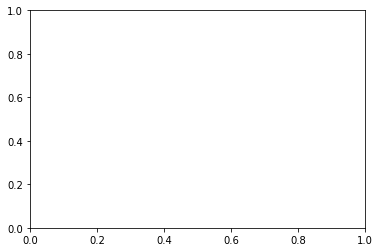

In [42]:
try:
    plot_scatter(data_pca)
except:
    raise ValueError("O DataFrame não cumpri os requisitos necessários.")

##  Parte 3 - Feature Selection & Dimensionality Reduction

Nessa próxima parte usaremos métodos de **Feature Selection** e **Dimensionality Reduction** para que possamos selecionar as melhores features do DataSet para serem usadas no nosso modelo.

### 3.1 - Random Forest

In [35]:
#Importa a biblioteca Random Forest
from sklearn.ensemble import RandomForestClassifier

#Aqui reusaremos o DataFrame do titanic e a coluna target
titanic
target

#Cria classificador passando seus parâmetros, neste momento usaremos apenas os default. 
#Parâmetros podem ser verificados no link abaixo
#http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
clf = RandomForestClassifier()

#Utilizamos a função .fit para treinar nosso modelo
clf.fit(titanic, target)

#Após o treinamento, podemos verificar o Feature Information do modelo gerado
clf.feature_importances_

array([0.05662591, 0.23978546, 0.23946969, 0.05324723, 0.03520829,
       0.2328507 , 0.03602961, 0.0109543 , 0.00734982, 0.01368906,
       0.00705176, 0.03399735, 0.00525851, 0.02848231])

### 3.2 - Decision Tree

In [39]:
#Importa a bilbioteca Decision Tree
from sklearn.tree import DecisionTreeClassifier

#Cria classificador passando seus parâmetros, neste momento usaremos apenas os default.
dtree = DecisionTreeClassifier()

dtree.fit(titanic,target)

dtree.feature_importances_

array([0.11316123, 0.30933519, 0.21254547, 0.04691217, 0.04163325,
       0.21943577, 0.01833539, 0.004546  , 0.00066296, 0.01652339,
       0.        , 0.        , 0.00994436, 0.00696482])

### 3.3 - Isomap

### 3.4 - TSNE (t-distributed Stochastic Neighbor Embedding)